##### Copyright 2018 The TensorFlow Probability Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TensorFlow Probability におけるガウス過程回帰

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/probability/examples/Gaussian_Process_Regression_In_TFP"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org で表示</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/probability/examples/Gaussian_Process_Regression_In_TFP.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab で実行</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/probability/examples/Gaussian_Process_Regression_In_TFP.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub でソースを表示</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/probability/examples/Gaussian_Process_Regression_In_TFP.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a></td>
</table>

この Colab では、TensorFlow と TensorFlow Probability を使用してガウス過程回帰を説明します。いくつかの既知の関数からノイズが含まれる観測を生成し、そのデータに GP モデルを適用します。次に、GP 事後分布からサンプルを取得して、それらの領域のグリッドにサンプリングされた関数の値をプロットします。


## 背景情報

$\mathcal{X}$ は任意のセットとします。*ガウス過程*（GP）は、${X_1, \ldots, X_n} \subset \mathcal{X}$ が有限サブセットである場合に周辺密度 $p(X_1 = x_1, \ldots, X_n = x_n)$ が多変量ガウスである $\mathcal{X}$ でインデックス化された確率変数の集合体です。ガウス分布は、その 1 次および 2 次中心モーメント（平均および共分散）によって完全に指定されるもので、GP もその例外ではありません。GP の平均関数 $\mu : \mathcal{X} \to \mathbb{R}$ と共分散関数 $k : \mathcal{X} \times \mathcal{X} \to \mathbb{R}$ に関して GP を完全に指定できます。GP のほとんどの表現力は、選択する共分散関数にカプセル化されています。さまざまな理由により、共分散関数は*カーネル関数*とも呼ばれており、対称的で整定値であることだけが要件です（[Rasmussen &amp; Williams の第 4 章](http://www.gaussianprocess.org/gpml/chapters/RW4.pdf)を参照）。以下では、ExponentiatedQuadratic 共分散カーネルを利用しています。次の形式です。

ここで、$\sigma^2$ は「偏角」、$\lambda$ は*長さスケール*と呼ばれます。カーネルパラメータは、最大尤度最適化プロシージャで選択できます。

GPからの完全なサンプルは、空間 $\mathcal{X}$ 全体にわたる実数値関数で構成されており、実際に実現するのは現実的といえないため、サンプルを観測するポイントのセットを選択し、これらのポイントで関数値を抽出するのが通例です。これは、適切な（有限次元の）多変量ガウスからサンプリングすることで実現できます。

上記の定義に従えば、有限次元の多変量ガウス分布もガウス過程であることに注意してください。通常、GP について言及した場合、インデックスセットが $\mathbb{R}^n$ であることは暗黙的であり、ここでは実際にこの仮定を行います。

機械学習におけるガウス過程の一般的なアプリケーションは、ガウス過程回帰です。有限のポイント数 ${x_1, \ldots x_N}$ で不明な関数のノイズを含む観測 ${y_1, \ldots, y_N}$ がある場合に、その関数を推定するという考えです。生成過程を次のように想像します。

上記に示すとおり、サンプリングされた関数は、無限のポイント数におけるその値が必要であるため、計算不可能です。代わりに、多変量ガウスから有限のサンプルを考慮することができます。

共分散行列の指数 $\frac{1}{2}$ に注目してください。これは、コレスキー分解を示しています。コレスキーの計算は、MVN がロケーションスケール族の分布であるため必要です。残念ながら、コレスキー分解は計算のコストが高く、$O(N^3)$ 時間と $O(N^2)$ 空間が掛かってしまいます。GP に関する文献のほとんどは、この一見無害に見える小さな指数を扱うことに焦点を当てています。

事前分布の平均関数を一定、多くの場合ゼロと見なすのが一般的です。また、何らかの表記法も役立ち、通常は、サンプリングされた関数値の有限ベクトルは $\mathbf{f}$ と記述されます。入力のペアに $k$ Aを適用した結果の共分散行列には、いくつかの興味深い表記法が使用されています。[(Quiñonero-Candela, 2005)](http://www.jmlr.org/papers/volume6/quinonero-candela05a/quinonero-candela05a.pdf) に従うと、行列のコンポーネントは特定の入力ポイントにおける関数値の共分散です。したがって、共分散行列を $K_{AB}$ と記述することができます。$A$ と $B$ は特定の行列次元に沿った関数値の集合体のインジケータです。

たとえば、観測データ $(\mathbf{x}, \mathbf{y})$ と暗示された潜在関数値 $\mathbf{f}$ がある場合、次のように記述することができます。

同様に、次のように、入力のセットを混合させることができます。

ここで、$N$ 個のトレーニング入力と $T$ 個のテスト入力があると仮定します。すると、上記の生成プロセスをコンパクト化して、次のように記述できます。

最初の行のサンプリング演算では、多変量ガウスから $N$ 個の関数値が取得され、*上記の GP の抽出表記のように関数全体ではありません*。2 行目は、さまざまな関数値で中心となる*単変量*ガウスからの $N$ 個の抽出の集合体を一定の観測ノイズ $\sigma^2$ で記述しています。

上記の生成モデルが準備されたところで、事後推論問題の検討に進むことができます。これは、新しいテストポイントのセットにおける関数値に対する事後分布を生成します。上記のプロセスから観測されたノイズ付きデータを条件としています。

上記の表記が準備できたので、対応する入力とトレーニングデータを条件として、未来の（ノイズ付き）観測事後予測分布を次のようにコンパクトに記述できます（詳細は、[Rasmussen &amp; Williams](http://www.gaussianprocess.org/gpml/) の §2.2 を参照）。

ここで、

および

$$ \begin{align} \mathbf{f} \sim : &amp; \textsf{MultivariateNormal} \left( \text{loc}=\mathbf{0}, \text{scale}=K_{\mathbf{f},\mathbf{f}}^{1/2} \right) \ y_i \sim : &amp; \textsf{Normal} \left( \text{loc}=f_i, \text{scale}=\sigma \right), i = 1, \ldots, N \end{align} $$

最初の行のサンプリング演算では、多変量ガウスから $N$ 個の関数値が取得され、*上記の GP の抽出表記のように関数全体ではありません*。2 行目は、さまざまな関数値で中心となる*単変量*ガウスからの $N$ 個の抽出の集合体を一定の観測ノイズ $\sigma^2$ で記述しています。

上記の生成モデルが準備されたところで、事後推論問題の検討に進むことができます。これは、新しいテストポイントのセットにおける関数値に対する事後分布を生成します。上記のプロセスから観測されたノイズ付きデータを条件としています。

上記の表記が準備できたので、対応する入力とトレーニングデータを条件として、未来の（ノイズ付き）観測事後予測分布を次のようにコンパクトに記述できます（詳細は、[Rasmussen &amp; Williams](http://www.gaussianprocess.org/gpml/) の §2.2 を参照）。

$$ \mathbf{y}^* \mid \mathbf{x}^<em data-md-type="emphasis">, \mathbf{x}, \mathbf{y} \sim \textsf{Normal} \left( \text{loc}=\mathbf{\mu}^</em>, \text{scale}=(\Sigma^*)^{1/2} \right), $$

where

$$ \mathbf{\mu}^* = K_{*,\mathbf{f}}\left(K_{\mathbf{f},\mathbf{f}} + \sigma^2 I \right)^{-1} \mathbf{y} $$

and

$$ \Sigma^* = K_{<em data-md-type="emphasis">,</em>} - K_{<em data-md-type="emphasis">,\mathbf{f}} \left(K_{\mathbf{f},\mathbf{f}} + \sigma^2 I \right)^{-1} K_{\mathbf{f},</em>} $$

## インポート

In [ ]:
import time

import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels
tf.enable_v2_behavior()

from mpl_toolkits.mplot3d import Axes3D
%pylab inline
# Configure plot defaults
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['grid.color'] = '#666666'
%config InlineBackend.figure_format = 'png'

Populating the interactive namespace from numpy and matplotlib


## 例: ノイズの多い正弦波データに対する正確な GP 回帰

ここでは、ノイズの多い正弦波からトレーニングデータを生成し、GP 回帰モデルの事後分布から多数の曲線をサンプリングします。カーネルハイパーパラメータの最適化には、[ADaM](https://arxiv.org/abs/1412.6980) を使用します（事前分布の負の対数尤度を最小化します）。トレーニング曲線をプロットしてから、実際の関数と事後分布のサンプルをプロットします。

In [ ]:
def sinusoid(x):
  return np.sin(3 * np.pi * x[..., 0])

def generate_1d_data(num_training_points, observation_noise_variance):
  """Generate noisy sinusoidal observations at a random set of points.

  Returns:
     observation_index_points, observations
  """
  index_points_ = np.random.uniform(-1., 1., (num_training_points, 1))
  index_points_ = index_points_.astype(np.float64)
  # y = f(x) + noise
  observations_ = (sinusoid(index_points_) +
                   np.random.normal(loc=0,
                                    scale=np.sqrt(observation_noise_variance),
                                    size=(num_training_points)))
  return index_points_, observations_

In [ ]:
# Generate training data with a known noise level (we'll later try to recover
# this value from the data).
NUM_TRAINING_POINTS = 100
observation_index_points_, observations_ = generate_1d_data(
    num_training_points=NUM_TRAINING_POINTS,
    observation_noise_variance=.1)

事前分布をカーネルハイパーパラメータに置き、`tfd.JointDistributionNamed` を使ってそのハイパーパラメータと観測データの同時分布を記述します。

In [ ]:
def build_gp(amplitude, length_scale, observation_noise_variance):
  """Defines the conditional dist. of GP outputs, given kernel parameters."""

  # Create the covariance kernel, which will be shared between the prior (which we
  # use for maximum likelihood training) and the posterior (which we use for
  # posterior predictive sampling)
  kernel = tfk.ExponentiatedQuadratic(amplitude, length_scale)

  # Create the GP prior distribution, which we will use to train the model
  # parameters.
  return tfd.GaussianProcess(
      kernel=kernel,
      index_points=observation_index_points_,
      observation_noise_variance=observation_noise_variance)

gp_joint_model = tfd.JointDistributionNamed({
    'amplitude': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'length_scale': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'observation_noise_variance': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'observations': build_gp,
})

事前分布からサンプリングできることを検証して実装の健全性チェックを行い、サンプルの対数密度を計算することができます。

In [ ]:
x = gp_joint_model.sample()
lp = gp_joint_model.log_prob(x)

print("sampled {}".format(x))
print("log_prob of sample: {}".format(lp))

sampled {'observation_noise_variance': <tf.Tensor: shape=(), dtype=float64, numpy=2.067952217184325>, 'length_scale': <tf.Tensor: shape=(), dtype=float64, numpy=1.154435715487831>, 'amplitude': <tf.Tensor: shape=(), dtype=float64, numpy=5.383850737703549>, 'observations': <tf.Tensor: shape=(100,), dtype=float64, numpy=
array([-2.37070577, -2.05363838, -0.95152824,  3.73509388, -0.2912646 ,
        0.46112342, -1.98018513, -2.10295857, -1.33589756, -2.23027226,
       -2.25081374, -0.89450835, -2.54196452,  1.46621647,  2.32016193,
        5.82399989,  2.27241034, -0.67523432, -1.89150197, -1.39834474,
       -2.33954116,  0.7785609 , -1.42763627, -0.57389025, -0.18226098,
       -3.45098732,  0.27986652, -3.64532398, -1.28635204, -2.42362875,
        0.01107288, -2.53222176, -2.0886136 , -5.54047694, -2.18389607,
       -1.11665628, -3.07161217, -2.06070336, -0.84464262,  1.29238438,
       -0.64973999, -2.63805504, -3.93317576,  0.65546645,  2.24721181,
       -0.73403676,  5.31628298

次に、最も高い事後確率を持つパラメータ値を見つけられるように最適化しましょう。各パラメータの変数を定義し、その値が正になるように制約をかけます。

In [ ]:
# Create the trainable model parameters, which we'll subsequently optimize.
# Note that we constrain them to be strictly positive.

constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())

amplitude_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='amplitude',
    dtype=np.float64)

length_scale_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='length_scale',
    dtype=np.float64)

observation_noise_variance_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='observation_noise_variance_var',
    dtype=np.float64)

trainable_variables = [v.trainable_variables[0] for v in 
                       [amplitude_var,
                       length_scale_var,
                       observation_noise_variance_var]]

モデルに観測データの条件を付けるために、`target_log_prob` 関数を定義します。これは、（推論が必要な）カーネルハイパーパラメータをとります。

In [ ]:
def target_log_prob(amplitude, length_scale, observation_noise_variance):
  return gp_joint_model.log_prob({
      'amplitude': amplitude,
      'length_scale': length_scale,
      'observation_noise_variance': observation_noise_variance,
      'observations': observations_
  })

In [ ]:
# Now we optimize the model parameters.
num_iters = 1000
optimizer = tf.optimizers.Adam(learning_rate=.01)

# Use `tf.function` to trace the loss for more efficient evaluation.
@tf.function(autograph=False, jit_compile=False)
def train_model():
  with tf.GradientTape() as tape:
    loss = -target_log_prob(amplitude_var, length_scale_var,
                            observation_noise_variance_var)
  grads = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(grads, trainable_variables))
  return loss

# Store the likelihood values during training, so we can plot the progress
lls_ = np.zeros(num_iters, np.float64)
for i in range(num_iters):
  loss = train_model()
  lls_[i] = loss

print('Trained parameters:')
print('amplitude: {}'.format(amplitude_var._value().numpy()))
print('length_scale: {}'.format(length_scale_var._value().numpy()))
print('observation_noise_variance: {}'.format(observation_noise_variance_var._value().numpy()))

Trained parameters:
amplitude: 0.9176153445125278
length_scale: 0.18444082442910079
observation_noise_variance: 0.0880273312850989


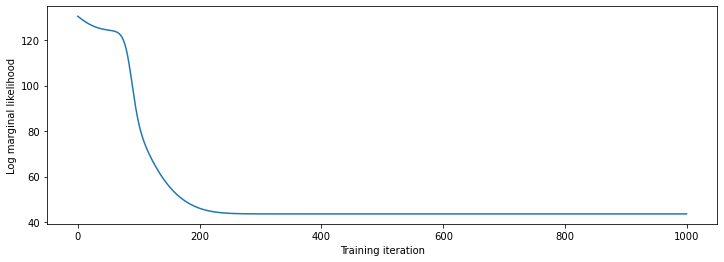

In [ ]:
# Plot the loss evolution
plt.figure(figsize=(12, 4))
plt.plot(lls_)
plt.xlabel("Training iteration")
plt.ylabel("Log marginal likelihood")
plt.show()

In [ ]:
# Having trained the model, we'd like to sample from the posterior conditioned
# on observations. We'd like the samples to be at points other than the training
# inputs.
predictive_index_points_ = np.linspace(-1.2, 1.2, 200, dtype=np.float64)
# Reshape to [200, 1] -- 1 is the dimensionality of the feature space.
predictive_index_points_ = predictive_index_points_[..., np.newaxis]

optimized_kernel = tfk.ExponentiatedQuadratic(amplitude_var, length_scale_var)
gprm = tfd.GaussianProcessRegressionModel(
    kernel=optimized_kernel,
    index_points=predictive_index_points_,
    observation_index_points=observation_index_points_,
    observations=observations_,
    observation_noise_variance=observation_noise_variance_var,
    predictive_noise_variance=0.)

# Create op to draw  50 independent samples, each of which is a *joint* draw
# from the posterior at the predictive_index_points_. Since we have 200 input
# locations as defined above, this posterior distribution over corresponding
# function values is a 200-dimensional multivariate Gaussian distribution!
num_samples = 50
samples = gprm.sample(num_samples)

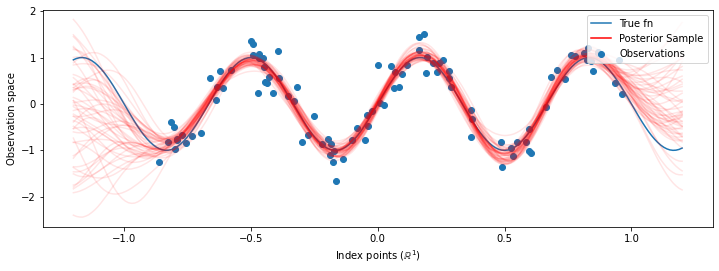

In [ ]:
# Plot the true function, observations, and posterior samples.
plt.figure(figsize=(12, 4))
plt.plot(predictive_index_points_, sinusoid(predictive_index_points_),
         label='True fn')
plt.scatter(observation_index_points_[:, 0], observations_,
            label='Observations')
for i in range(num_samples):
  plt.plot(predictive_index_points_, samples[i, :], c='r', alpha=.1,
           label='Posterior Sample' if i == 0 else None)
leg = plt.legend(loc='upper right')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel(r"Index points ($\mathbb{R}^1$)")
plt.ylabel("Observation space")
plt.show()

*注意: 上記のコードを何度か実行すると、うまく実行しているように見えることもあれば、まったく酷いこともあります！パラメータの最大尤度トレーニングは非常に感度が高いため、質の悪いモデルに収束してしまうことがあるのです。MCMC を使用してモデルのハイパーパラメータを周辺化することをお勧めします。*

## HMC を使用してハイパーパラメータを周辺化する

ハイパーパラメータを最適化する代わりに、ハミルトニアンモンテカルロを使ってハイパーパラメータを統合してみましょう。まずサンプラーを定義して実行し、観測値を前提として、カーネルハイパーパラメータの事後分布からおおよそ抽出します。

In [ ]:
num_results = 100
num_burnin_steps = 50

sampler = tfp.mcmc.TransformedTransitionKernel(
    tfp.mcmc.NoUTurnSampler(
        target_log_prob_fn=target_log_prob,
        step_size=tf.cast(0.1, tf.float64)),
    bijector=[constrain_positive, constrain_positive, constrain_positive])

adaptive_sampler = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=sampler,
    num_adaptation_steps=int(0.8 * num_burnin_steps),
    target_accept_prob=tf.cast(0.75, tf.float64))

initial_state = [tf.cast(x, tf.float64) for x in [1., 1., 1.]]

In [ ]:
# Speed up sampling by tracing with `tf.function`.
@tf.function(autograph=False, jit_compile=False)
def do_sampling():
  return tfp.mcmc.sample_chain(
      kernel=adaptive_sampler,
      current_state=initial_state,
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      trace_fn=lambda current_state, kernel_results: kernel_results)

t0 = time.time()
samples, kernel_results = do_sampling()
t1 = time.time()
print("Inference ran in {:.2f}s.".format(t1-t0))

Inference ran in 9.00s.


ハイパーパラメータのトレースを調べて、サンプラーの健全性チェックを行いましょう。 

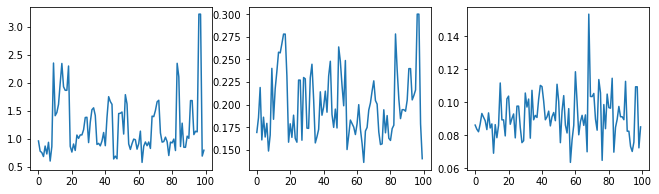

In [ ]:
(amplitude_samples,
 length_scale_samples,
 observation_noise_variance_samples) = samples

f = plt.figure(figsize=[15, 3])
for i, s in enumerate(samples):
  ax = f.add_subplot(1, len(samples) + 1, i + 1)
  ax.plot(s)

次に、最適化されたハイパーパラメータで単一の GP を構築する代わりに、ハイパーパラメータの事後分布からのサンプルによって定義され GP の混合として*事後予測分布*を構築します。これは、モンテカルロサンプリングを介して事後パラメータをほぼ統合し、観測されていない場所での周辺予測分布を計算します。

In [ ]:
# The sampled hyperparams have a leading batch dimension, `[num_results, ...]`,
# so they construct a *batch* of kernels.
batch_of_posterior_kernels = tfk.ExponentiatedQuadratic(
    amplitude_samples, length_scale_samples)

# The batch of kernels creates a batch of GP predictive models, one for each
# posterior sample.
batch_gprm = tfd.GaussianProcessRegressionModel(
    kernel=batch_of_posterior_kernels,
    index_points=predictive_index_points_,
    observation_index_points=observation_index_points_,
    observations=observations_,
    observation_noise_variance=observation_noise_variance_samples,
    predictive_noise_variance=0.)

# To construct the marginal predictive distribution, we average with uniform
# weight over the posterior samples.
predictive_gprm = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(logits=tf.zeros([num_results])),
    components_distribution=batch_gprm)

num_samples = 50
samples = predictive_gprm.sample(num_samples)

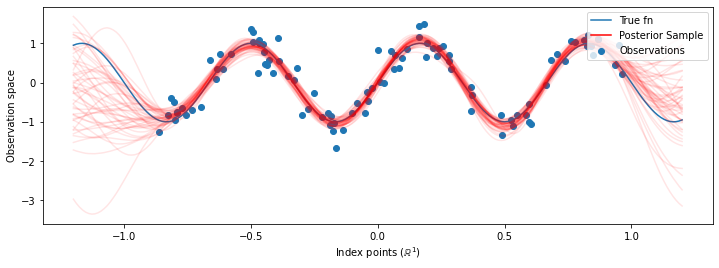

In [ ]:
# Plot the true function, observations, and posterior samples.
plt.figure(figsize=(12, 4))
plt.plot(predictive_index_points_, sinusoid(predictive_index_points_),
         label='True fn')
plt.scatter(observation_index_points_[:, 0], observations_,
            label='Observations')
for i in range(num_samples):
  plt.plot(predictive_index_points_, samples[i, :], c='r', alpha=.1,
           label='Posterior Sample' if i == 0 else None)
leg = plt.legend(loc='upper right')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel(r"Index points ($\mathbb{R}^1$)")
plt.ylabel("Observation space")
plt.show()

この場合での違いは些細ではありますが、上記のように最も可能性の高いパラメータを使用するよりも、事後予測分布の方が一般化する（データが保持される可能性が高くなる）ことが期待されます。